# Day 13 - Breakout!

<figure style="float: right; max-width: 12em; margin: 1em">
<img src="https://upload.wikimedia.org/wikipedia/en/a/a2/Arkanoid.png"
     alt="Screenshot of Arkanoid" width="150"/>
<figcaption style="font-style: italic; font-size: smaller">

Screenshot of Arkanoid.  
Intellectual property owned by Taito, sourced [from Wikipedia](https://en.wikipedia.org/wiki/File:Arkanoid.png).

</figcaption>
</figure>


* https://adventofcode.com/2019/day/13

Today we are given the code for an arcade game. For someone of my vintage, it is instantly recognisable as [Breakout](https://en.wikipedia.org/wiki/Breakout_(video_game)). I've lost many an hour trying to variants like the excellent [Taito's *Arkanoid*](https://en.wikipedia.org/wiki/Arkanoid), on my venerable [MSX](https://en.wikipedia.org/wiki/MSX), way back in the 1980s.

For part 1, all we are asked to do is run the provided Intcode and tally how many block tiles it are output. We naturally also want to see what the game actually *looks* like, so I'm adding a simple PIL image generator.

Because I suspect we'll also be tasked to provide automated input (perhaps to *play* this game?) I'm going to use the same approach as for the [ship-painting robot](http://localhost:8888/notebooks/2019/Day%2011.ipynb): a generator.

In [1]:
from __future__ import annotations
from dataclasses import dataclass, field
from enum import Enum
from io import BytesIO
from typing import (
    overload,
    ContextManager,
    Dict,
    Generator,
    Iterable,
    List,
    MutableMapping,
    Optional,
    Tuple,
    TYPE_CHECKING
)

import numpy as np
from IPython.display import display
from PIL import Image
from PIL.ImagePalette import ImagePalette
from matplotlib.cm import get_cmap

from intcode import CPU, Instruction, InstructionSet, base_opcodes


Pos = Tuple[int, int]
Colour = Tuple[int, int, int]

TILESIZE = (16, 10)


class BreakoutTile(Enum):
    # value output by Intcode, optional colour or None, patch bytes (20)
    empty =  0, (   0,    0,    0), b'\x00' * 20
    wall =   1, (0x80, 0x80, 0x80), b'\xff' * 20
    block =  2, None              , b'\x00\x00'  + b'\x7f\xfe' * 8 + b'\x00\x00'
    paddle = 3, (0xe0, 0xe0, 0xe0), b'\x00\x00' * 3  + b'\xff\xff' * 4 + b'\x00\x00' * 3
    ball =   4, (0xff, 0xff, 0xff), b'\x00\x00\x03\xc0\x07\xe0\x0f\xf0\x0f\xf0\x0f\xf0\x0f\xf0\x07\xe0\x03\xc0\x00\x00'
    
    if TYPE_CHECKING:
        _colour: Optional[Colour]
        _img: Image.Image
        _patch: Optional[np.array]
    
    def __new__(
        self,
        value: int,
        colour: Optional[Colour] = None,
        patch: Optional[bytes] = None
    ) -> BreakoutTile:
        self = object.__new__(self)
        self._value_ = value
        self.colour = colour

        # turn the bits of the patch bytes into a numpy array for easy
        # colour manipulation.
        patch = np.unpackbits(
            np.frombuffer(patch, dtype=np.uint8).reshape(-1, TILESIZE[0] // 8),
            axis=1
        )
        if colour is not None:
            # actual colour value used is a palette index, with
            # empty and wall being 0 and 1, and paddle and ball
            # getting 2 and 3.
            pcolour = value - (value > 2)
            self._img = img = Image.fromarray(patch * pcolour, "P")
            self._patch = None
        else:
            # blocks get a colour assigned on rendering
            self._img = None
            self._patch = patch

        return self
    
    def put(self, screen: Image, pos: Pos) -> None:
        img = self._img
        if img is None:
            assert self._patch is not None
            colour = 4 + ((pos[0] << 8 | pos[1]) % 252)
            img = Image.fromarray(self._patch * colour, "P")
        screenpos = pos[0] * TILESIZE[0], pos[1] * TILESIZE[1]
        screen.paste(img, screenpos)


# take an imagemagic color map and turn it into a PIL palette, by
# calling the map with an array, asking for bytes. Then
# pass that, flattened by column ('F'ortran order) to ImagePalette
# We size the array to allow for 252 colours, so we have
# space for fixed colours for paddle, walls, background and ball.
# Note that we need to drop the Alpha column first.
PALETTE: ImagePalette = ImagePalette(
    "RGB",
    np.concatenate(
        (
            np.array([t.colour for t in BreakoutTile if t.colour is not None]),
            get_cmap("gist_rainbow")(
                    np.linspace(0., 1., 252),
                    None,
                    True,
                )[:, :-1]
        )
    ).ravel("F").tolist()
)


@dataclass
class BreakoutScreen(MutableMapping[Pos, BreakoutTile]):
    _tiles: Dict[Pos, BreakoutTile] = field(default_factory=dict)
    _xrange: range = range(0)
    _yrange: range = range(0)
    _image: Optional[Image.Image] = None
        
    def _create_image(self, width: int, height: int) -> Image.Image:
        self._image = img = Image.new('P', (width, height))
        img.putpalette(PALETTE)
        return img
        
    def _update_image(
        self,
        pos: Optional[Pos] = None,
        tile: Optional[BreakoutTile] = None
    ) -> None:
        old = self._xrange, self._yrange
        if pos is not None:
            x, y = pos        
            if x < self._xrange.start:
                self._xrange = range(x, self._xrange.stop)
            elif x >= self._xrange.stop:
                self._xrange = range(self._xrange.start, x + 1)
            if y < self._yrange.start:
                self._yrange = range(y, self._yrange.stop)
            elif y >= self._yrange.stop:
                self._yrange = range(self._yrange.start, y + 1)
        else:
            self._xrange = range(
                min(x for x, _ in self._tiles),
                max(x for x, _ in self._tiles) + 1,
            )
            self._yrange = range(
                min(y for _, y in self._tiles),
                max(y for _, y in self._tiles) + 1,
            )

        if (self._xrange, self._yrange) != old:
            minx, miny = self._xrange.start, self._yrange.start
            W, H = len(self._xrange) * TILESIZE[0], len(self._yrange) * TILESIZE[1]
            img = self._create_image(W, H)
            for pos, tile in self._tiles.items():
                tile.put(img, pos)
        elif pos is not None and tile is not None:
            tile.put(self._image, pos)

    def __iter__(self) -> Iterable[Tuple[Pos, BreakoutTile]]:
        return iter(self._tiles.items())
    
    def __len__(self) -> int:
        return len(self._tiles)

    def __getitem__(self, pos: Pos) -> BreakoutTile:
        return self._tiles.get(pos, BreakoutTile.empty)
    
    def __setitem__(self, pos: Pos, tile: BreakoutTile) -> None:
        if tile is BreakoutTile.empty:
            self._tiles.pop(pos, None)
            self._update_image()
            if pos[0] in self._xrange and pos[1] in self._yrange:
                BreakoutTile.empty.put(self._image, pos)
        else:
            self._tiles[pos] = tile
            self._update_image(pos, tile)

    def __delitem__(self, pos: Pos) -> None:
        del self._tiles[pos]
        self._update_image()
        if pos[0] in self._xrange and pos[1] in self._yrange:
            BreakoutTile.empty.put(pos)
        
    def _repr_png_(self) -> bytes:
        img = self._image
        if img is None:
            img = Image.new('P', (1, 1))
        f = BytesIO()
        img.save(f, "PNG")
        return f.getvalue()


ArcadeRunner = Generator[None, int, None]


class Arcade(ContextManager[ArcadeRunner]):
    screen: BreakoutScreen
    _runner: Optional[ArcadeRunner] = None

    def __init__(self):
        self.screen = BreakoutScreen()
        
    def powerdown(self) -> None:
        if self._runner is not None:
            self._runner.close()
            self._runner = None
    
    def __enter__(self) -> ArcadeRunner:
        if self._runner is None:
            self._runner = self.run()
            # prime the runner, so it is waiting for input
            next(self._runner)
        return self._runner
    
    def __exit__(self, *exc) -> None:
        self.powerdown()
        
    def run(self) -> Generator[None, int, None]:
        while True:
            pos = ((yield None), (yield None))
            tile = BreakoutTile((yield None))
            self.screen[pos] = tile
    
    def _repr_png_(self):
        return self.screen._repr_png_()

            
def count_blocks(memory: List[int]) -> int:
    arcade = Arcade()
    with arcade as runner:
        opcodes: InstructionSet = {
            **base_opcodes,
            4: Instruction(runner.send, 1),
        }
        CPU(opcodes).reset(memory).execute()
    display(arcade)
    return sum(1 for _, tile in arcade.screen if tile is BreakoutTile.block)

In [2]:
import aocd
data = aocd.get_data(day=13, year=2019)
memory = list(map(int, data.split(',')))

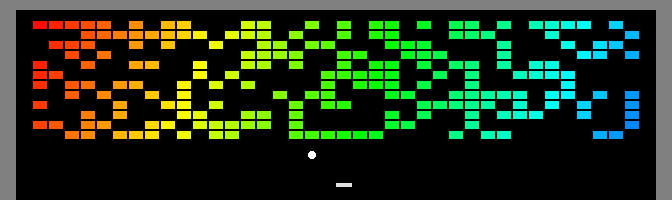

Part 1: 207


In [3]:
print("Part 1:", count_blocks(memory))

## Part 2 - Playing the game

We are indeed asked to take control of the game! So our Arcade runner will need to keep the paddle as close as possible to the ball. We'll also need to add a score display.

For the joystick, we need to track the position of the ball, and the paddle. Whenever the paddle is to the right of the ball, move left, and when it is to the left, move right, and if we are at the same position, don't move. Simple, right?

We'll send the joystick output by simply providing the current reading each time the program wants to read it.

In [4]:
from functools import partial
from io import BytesIO
from zipfile import ZipFile
from typing import Literal

import requests
from IPython.display import display, DisplayHandle
from PIL import ImageFont, ImageDraw


JOYSTICK = Literal[-1, 0, 1]
SCORE_UPDATE: Pos = (-1, 0)

# Pizzadude.dk "Arcade Classic" TTF, free for personal use
# download into memory directly from the webs.
with ZipFile(BytesIO(requests.get("https://dl.dafont.com/dl/?f=arcade_ya").content)) as zf:
    FONT = ImageFont.truetype(zf.open("ARCADE_R.TTF"), 14)

class BreakoutScreenWithScore(BreakoutScreen):
    def _create_image(self, width: int, height: int) -> Image.Image:
        return super()._create_image(width, height + 20)
  
    def update_score(self, score: int, _font=FONT) -> None:
        img = self._image
        draw = ImageDraw.Draw(img)

        text = f"Credits: 99   Player: 1  Score: {score:06d}"
        width, height = _font.getsize(text)
        pos = ((img.width - width) // 2, img.height - 10 - (height // 2))

        draw.rectangle([pos, (pos[0] + width, pos[1] + height)], fill=0)
        draw.text(pos, text, fill=3, font=_font)

class AutoPlayingArcade(Arcade):
    joystick: JOYSTICK = 0
    score: int = 0
    _display_handle: DisplayHandle
    _ball: Optional[int] = None
    _paddle: Optional[int] = None
        
    def __init__(self) -> None:
        self.screen = BreakoutScreenWithScore()
        self._display_handle = display(self, display_id=True)
        
    def update_screen(self) -> None:
        self._display_handle.update(self)
        
    def run(self) -> Generator[None, int, None]:
        while True:
            pos = ((yield None), (yield None))
            value = yield None
            
            if pos == SCORE_UPDATE:
                self.score = value
                self.screen.update_score(self.score)

            else:
                tile = BreakoutTile(value)
                self.screen[pos] = tile
                if tile is BreakoutTile.ball:
                    x, _ = pos
                    self._ball = x
                    paddle = self._paddle if self._paddle is not None else x
                    self.joystick = (paddle < x) - (paddle > x)
                elif tile is BreakoutTile.paddle:
                    x, _ = pos
                    self._paddle = x
                    ball = self._ball if self._ball is not None else x
                    self.joystick = (x < ball) - (x > ball)

            if self._paddle and self._ball:
                # only update once we have a reasonably full screen to show.
                self.update_screen()

def play(memory: List[int]) -> int:
    arcade = AutoPlayingArcade()
    with arcade as runner:
        opcodes: InstructionSet = {
            **base_opcodes,
            3: Instruction(partial(getattr, arcade, "joystick"), output=True),
            4: Instruction(runner.send, 1),
        }
        CPU(opcodes).reset([2, *memory[1:]]).execute()
    return arcade.score

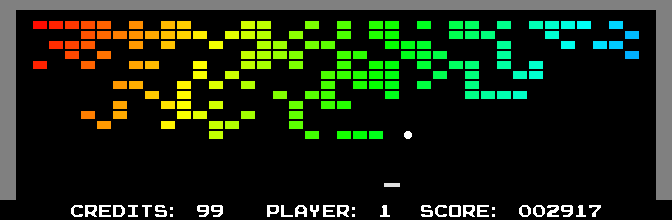

In [ ]:
print("Part 2:", play(memory))

## I am totally in awe of how well this runs

The above code runs the IntCode CPU in real time, and if you run this locally then the display you see is the actual game being played, at very impressive speeds. Remember that this is all *pure Python code*, running a VM, driving a generator, which triggers updates to a PIL image, and tells IPython to refresh the display in a browser, for every little change.

At this point I'm totally in awe; *I am very impressed with the design of this puzzle*. The IntCode provided is barely more than 2Kb, IntCode has a sum total of 10 opcodes and 1 register. It beautifully illustrates how simple classic arcade machines really were.

For those that read this in a notebook reader or on GitHub: the above is merely a snapshot in time. However, below is a GIF capture of the game being played in my notebook:

![](aoc201913-breakout.gif)